## Projet 6 -  Faisabilité - Classifiez automatiquement des biens de consommation en utilisant l'apprentissage profond (Deep Learning) et le Transfer Learning VGG16 (méthode de complexité moyenne) et une methode avec un modèle simple comme Lenet5 (méthode de complexité faible)
 Il s'agit ici rapidement de vérifier la faisabilité de la classification supervisée en utilisant le Transfer Learning VGG16. Si la faisabilité est confirmée, nous pourrons alors passer à la partie 2 de classification supervisée dans l'autre notebook P6_03....


## CNN Transfer Learning en utilisant VGG-16
Ce notebook présente une approche de classification d'images en utilisant le transfert d'apprentissage avec le modèle VGG-16. Le projet consiste à classer automatiquement des biens de consommation en fonction d'images de produits. Le notebook couvre au début les memes étapes que pour le notebook SIFT, mais en utilisant un modèle CNN pré-entrainé VGG-16 pour l'extraction des features.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


## Chargement et Prétraitement des Données
Ici, nous chargeons et prétraitons nos données d'image, en nous alignant sur les méthodes utilisées dans le notebook SIFT."

In [45]:
import pandas as pd
import os

# Définir le chemin relatif
file_path = os.path.join("..", "data", "flipkart_com-ecommerce_sample_1050.csv")

# Charger le CSV dans un DataFrame
df = pd.read_csv(file_path)

# premières lignes du df
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


### Import du dataset des images sous forme de fichiers jpg


Image: 009099b1f6e1e8f893ec29a7023153c4.jpg
 - Dimensions: (687, 1162)
 - Mode: RGB
------------------------------
Image: 0096e89cc25a8b96fb9808716406fe94.jpg
 - Dimensions: (1478, 904)
 - Mode: RGB
------------------------------
Image: 00cbbc837d340fa163d11e169fbdb952.jpg
 - Dimensions: (1347, 326)
 - Mode: RGB
------------------------------
Image: 00d84a518e0550612fcfcba3b02b6255.jpg
 - Dimensions: (1100, 857)
 - Mode: RGB
------------------------------
Image: 00e966a5049a262cfc72e6bbf68b80e7.jpg
 - Dimensions: (962, 1100)
 - Mode: RGB
------------------------------
Image: 00ed03657cedbe4663eff2d7fa702a33.jpg
 - Dimensions: (788, 2430)
 - Mode: RGB
------------------------------


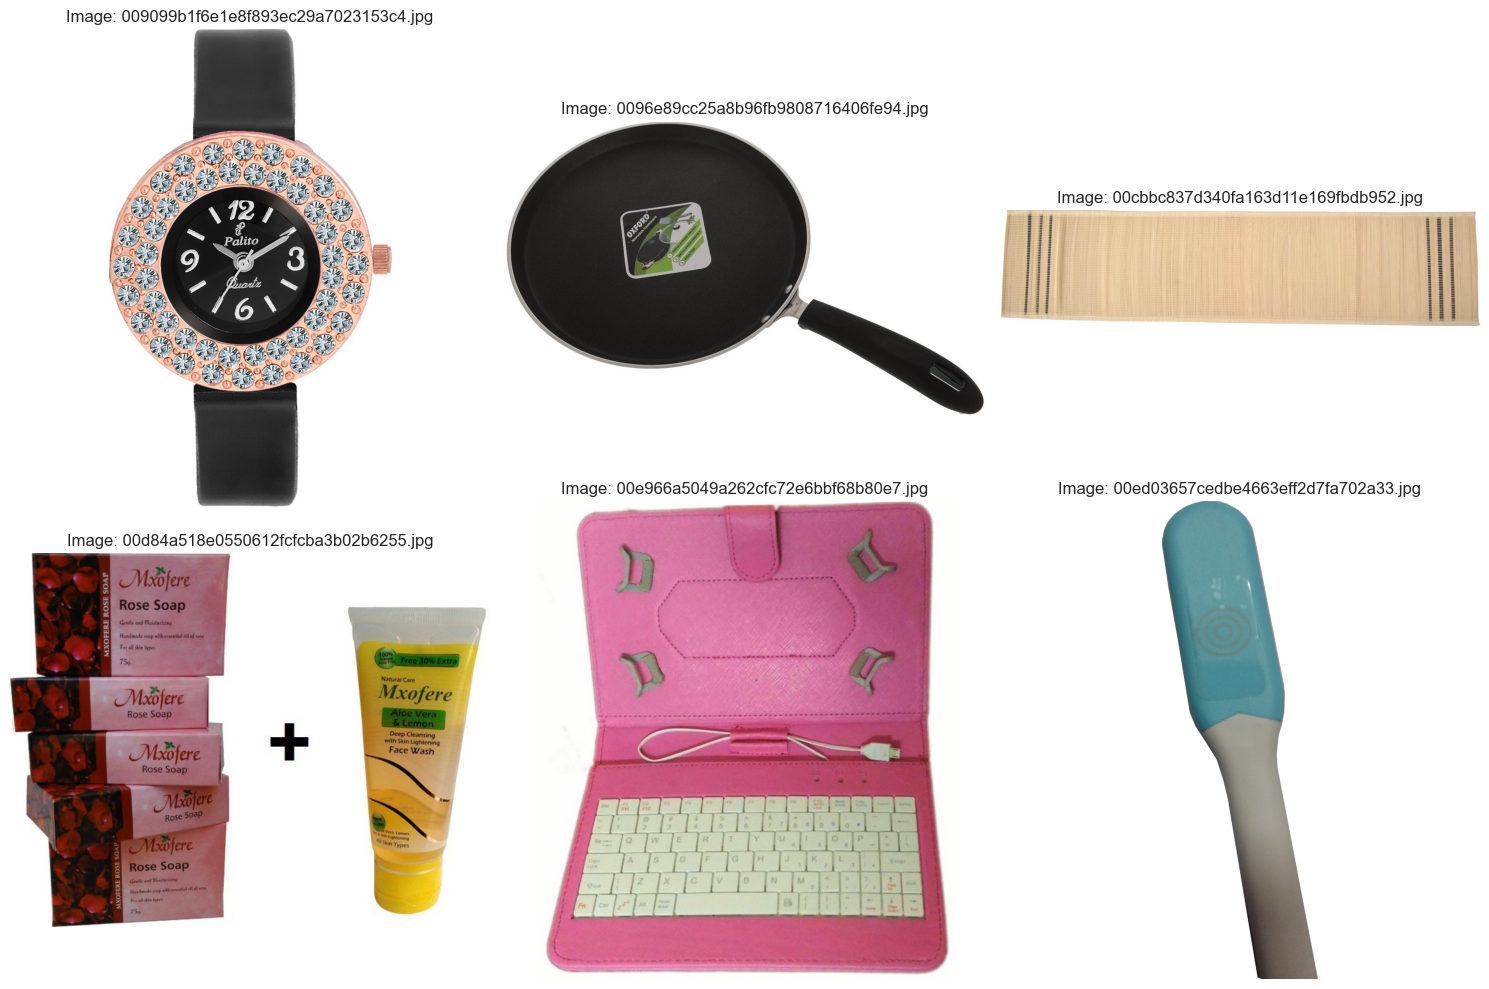

In [46]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Définir le chemin du dossier contenant les images
images_folder = os.path.join("..", "data", "Images")

# Lister tous les fichiers du dossier
image_files = os.listdir(images_folder)

# Sélectionner les 6 premières images
selected_images = image_files[:6]

# Configurer la figure pour afficher 6 images (2 lignes, 3 colonnes)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Charger et afficher les informations sur chaque image
for i, image_name in enumerate(selected_images):
    image_path = os.path.join(images_folder, image_name)
    image = Image.open(image_path)
    
    # Afficher les informations sur l'image
    print(f"Image: {image_name}")
    print(f" - Dimensions: {image.size}")
    print(f" - Mode: {image.mode}")
    print("-" * 30)
    
    # Afficher l'image dans la grille
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(f"Image: {image_name}")
    ax.axis('off')  # Retourner les axes pour une meilleure visibilité

# Afficher la grille
plt.tight_layout()
plt.show()



In [47]:

import pandas as pd

# Charger les données dans un DataFrame
df = pd.read_csv('../data/flipkart_com-ecommerce_sample_1050.csv')

# Afficher les valeurs uniques de la colonne 'product_category_tree'
print(df['product_category_tree'].unique())

# Extraire la première catégorie de la colonne 'product_category_tree'
df['category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].strip())

# Mettre la catégorie en minuscules
df['category'] = df['category'].apply(lambda x: x.lower())

# Afficher les valeurs uniques de la colonne 'category'
print(df['category'].unique())


['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'
 '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'
 '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]'
 '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]'
 '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]'
 '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]'
 '["Watches >> Wrist Watches >> Camerii Wrist Watches"]'
 '["Watches >> Wrist Watches >> T STAR Wrist Watches"]'
 '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]'
 '["Watches >> Wrist Watches >> TAG Heuer Wrist Watches"]'
 '["Watches >> Wrist Watches >> Calibro Wri

### Recuperation de la première catégorie de produits

In [48]:
# Afficher les valeurs uniques de la colonne 'product_category_tree'
df['product_category_tree'].unique()

array(['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]',
       '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]',
       '["Watches >> Wrist Watches >> Camerii Wrist Watches"]',
       '["Watches >> Wrist Watches >> T STAR Wrist Watches"]',
       '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]',
       '["Watches >> Wrist Watches >> T

In [49]:
# Extraire la première catégorie de la colonne 'product_category_tree'
df['category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0][2:-1])

# Mettre la catégorie en minuscules et dans une liste
df['category'] = df['category'].apply(lambda x: x.lower())

# Afficher les valeurs uniques de la colonne 'category'
df['category'].unique()

array(['home furnishing', 'baby care', 'watches',
       'home decor & festive needs', 'kitchen & dining',
       'beauty and personal care', 'computers'], dtype=object)

In [50]:
# Afficher les premières lignes du DataFrame
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",baby care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",baby care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",home furnishing


# Creation du dataframe pour le traitement des images

In [51]:
# Créer un nouveau DataFrame avec les colonnes 'image' et 'category'
df_images = df.copy()
df_images = df_images[['image', 'category']]
df_images.head()

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing


### Création colonne label dans le DataFrame

In [52]:
from sklearn import preprocessing

# Initialiser l'encodeur de labels
le = preprocessing.LabelEncoder()

# Adapter l'encodeur de labels à la colonne 'category'
le.fit(df_images['category'])

# Transformer la colonne 'category' pour créer une nouvelle colonne 'label'
df_images['label'] = le.transform(df_images['category'])

# Créer une correspondance des labels de catégorie aux labels numériques
category_to_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Afficher la correspondance
print("Category to Label Mapping:")
print(category_to_label_mapping)

# Afficher le DataFrame mis à jour avec la nouvelle colonne 'label'
df_images.head(6)


Category to Label Mapping:
{'baby care': 0, 'beauty and personal care': 1, 'computers': 2, 'home decor & festive needs': 3, 'home furnishing': 4, 'kitchen & dining': 5, 'watches': 6}


,image,category,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,4
5,893aa5ed55f7cff2eccea7758d7a86bd.jpg,watches,6


In [53]:
df_images.groupby("label").count()

,image,category
label,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


In [54]:
print(df_images.columns)


Index(['image', 'category', 'label'], dtype='object')


baby care


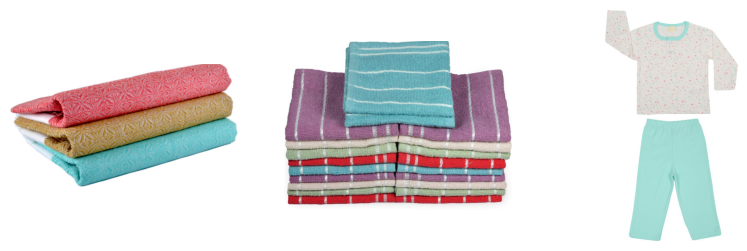

beauty and personal care


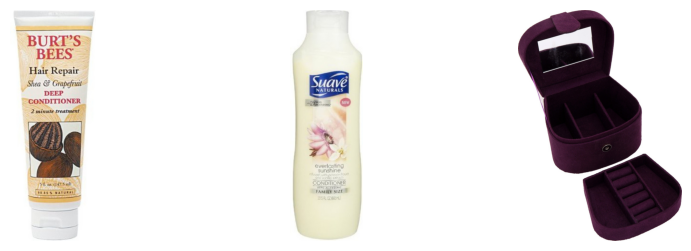

computers


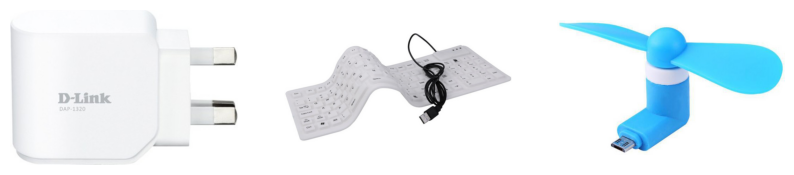

home decor & festive needs


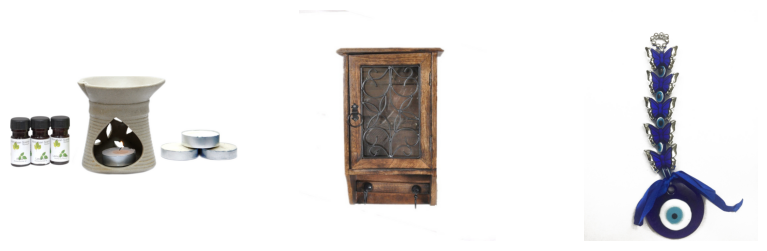

home furnishing


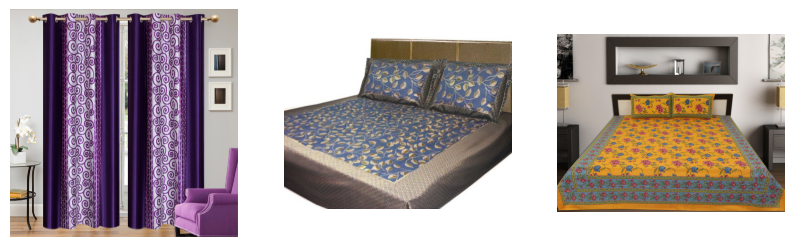

kitchen & dining


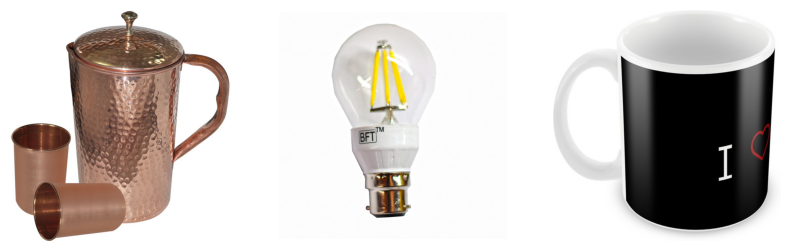

watches


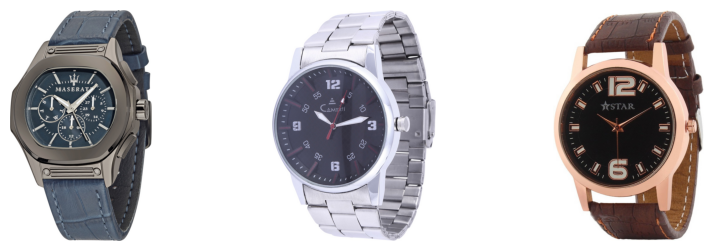

In [55]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os

# Mise à jour de la correspondance catégorie-label en fonction de votre mappage
category_to_label_mapping = {
    'baby care': 0, 
    'beauty and personal care': 1, 
    'computers': 2, 
    'home decor & festive needs': 3, 
    'home furnishing': 4, 
    'kitchen & dining': 5, 
    'watches': 6
}

# Fonction pour renvoyer une liste de chemins d'images en fonction de la catégorie textuelle
def list_images_by_category(df, category):
    label = category_to_label_mapping[category]
    return df[df['label'] == label]['image'].tolist()

# Afficher trois images pour chaque catégorie
for category in category_to_label_mapping.keys():
    print(category)
    image_list = list_images_by_category(df_images, category)
    plt.figure(figsize=(10, 3))  # Ajuster la taille de la figure
    for i in range(min(3, len(image_list))):  # Afficher au maximum 3 images
        plt.subplot(1, 3, i + 1)  # Configuration de la sous-figure
        filename = os.path.join(images_folder, image_list[i])  # S'assurer que le chemin est correct
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')  # Retourner les axes pour une meilleure visibilité
    plt.show()



# Etape 1 : étude de faisabilité

## Configuration du Modèle
Configurer le modèle CNN en utilisant VGG-16, adapté aux exigences spécifiques du projet. La dernière couche du modèle n'est pas utlisée, car nous allons utiliser les features extraites par les couches convolutionnelles pour la classification. L'avant-dernière couche est utilisée pour extraire les features des images.

In [56]:
# Cette ligne initialise le modèle VGG16 avec des poids entraînés sur l'ensemble de données ImageNet. Par défaut, il inclut les couches entièrement connectées supérieures. 
base_model = VGG16() 

# Cette ligne crée un nouveau modèle qui utilise les mêmes entrées que le modèle VGG16 mais ne produit que les sorties de l'avant-dernière couche du VGG16. Cela est souvent fait pour utiliser le modèle comme extracteur de caractéristiques dans des scénarios d'apprentissage par transfert, où la base convolutive du modèle est utilisée pour extraire des caractéristiques qui sont ensuite utilisées pour entraîner un nouveau classificateur.
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

# Cette ligne affiche un résumé de l'architecture du modèle, montrant les couches et le nombre de paramètres dans chaque couche.
print(model.summary())


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


### Observations :
1. **Configuration des couches :**
   - Le modèle inclut plusieurs couches convolutionnelles (`Conv2D`) et des couches de pooling (`MaxPooling2D`), typiques de l'architecture VGG.
   - Le nombre de filtres de convolution commence à 64 et double dans les couches plus profondes, atteignant 512 dans les derniers blocs.
   - Chaque bloc de convolution est suivi d'une couche de pooling qui réduit les dimensions spatiales de la sortie.

2. **Dimensions de sortie :**
   - Chaque couche de convolution conserve la profondeur mais modifie les dimensions spatiales en raison des strides dans les convolutions et le pooling.
   - Le dernier bloc réduit les dimensions spatiales à 7x7 tout en conservant 512 canaux.

3. **Aplatissement et couches denses :**
   - La sortie du dernier bloc de convolution est aplatie en un vecteur 1D, ce qui est courant avant de l'alimenter dans des couches totalement connectées (Dense).
   - Il y a deux couches denses de 4096 unités chacune, suivies de fonctions d'activation (supposées être ReLU, bien que non spécifiées dans le résumé).

4. **Taille du modèle :**
   - Le modèle a un total de 134,260,544 paramètres, ce qui indique un réseau très profond avec une capacité substantielle à apprendre à partir de jeux de données grands et complexes.
   - Tous les paramètres sont entraînables, comme indiqué par l'absence de paramètres non entraînables.

### Considérations pour votre projet :
- **Intensité des ressources :** VGG16 est un modèle large et computationnellement intensif. Assurez-vous de disposer des ressources matérielles suffisantes (de préférence un GPU) pour l'entraînement et l'inférence.
- **Extraction de caractéristiques :** Si vous utilisez le modèle VGG16 principalement pour l'extraction de caractéristiques, envisagez de geler les couches convolutionnelles et de n'entraîner que les couches denses supérieures. Cela peut être plus efficace car la base convolutionnelle a déjà appris des caractéristiques robustes à partir du jeu de données ImageNet.
- **Personnalisation pour des tâches spécifiques :** Comme votre projet implique la classification d'images en catégories spécifiques, vous pourriez remplacer la ou les couches supérieures pour correspondre au nombre de vos classes cibles.



### Extraction des features des images

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import os
from PIL import Image

# S'assurer que PIL ne génère pas d'avertissement DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = None  # Permettre la lecture d'images de grande taille

images_features = [] 
i = 0

# Assurez-vous que 'df_images' est votre DataFrame et qu'il contient une colonne 'image' avec les noms de fichiers des images
for image_file in df_images['image']:
    if i % 100 == 0:
        print(f'Processing image {i}')  # Afficher la progression toutes les 100 images
    i += 1
    image_path = os.path.join(images_folder, image_file)  # Construire le chemin de l'image
    
    # Charger et redimensionner l'image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)  # Convertir l'image en tableau numpy
    image = np.expand_dims(image, axis=0)  # Ajouter une dimension pour créer un lot d'images
    image = preprocess_input(image)  # Pretraiter l'image pour l'adapter au modèle
    
    # Prédire les caractéristiques en utilisant le modèle et les ajouter à la liste
    images_features.append(model.predict(image, verbose=0)[0])

# Convertir la liste de caractéristiques en un tableau numpy
images_features = np.asarray(images_features)
print(f'Features shape: {images_features.shape}')  # Afficher la forme des caractéristiques


Processing image 0


### Réduction de dimension PCA

### Observations :
- Le résultat du traitement montre que l'extraction de caractéristiques a été réalisée avec succès sur un total de 1050 images. Chaque image a été traitée pour extraire des vecteurs de caractéristiques de taille 4096, ce qui est conforme à ce que l'on attend du modèle VGG16 utilisé jusqu'aux couches denses. Le script a effectué un suivi régulier du processus en affichant un message à chaque centaine d'images traitées, et il n'y a pas eu d'interruptions durant le traitement.

- La forme finale du tableau `images_features` est (1050, 4096), indiquant que les caractéristiques de 1050 images ont été extraites et que chaque ensemble de caractéristiques est représenté par un vecteur de 4096 éléments. Cette sortie confirme que le processus d'extraction des caractéristiques fonctionne comme prévu.

In [15]:
from sklearn import manifold, decomposition

# En supposant que images_features est un tableau où chaque ligne représente les caractéristiques extraites d'une image
print("Original features shape:", images_features.shape)

# Appliquer l'ACP pour réduire les dimensions tout en conservant 99 % de la variance
pca = decomposition.PCA(n_components=0.99)  # Retenir 99 % de la variance
feat_pca = pca.fit_transform(images_features)  # Transformer les caractéristiques

print("Reduced features shape after PCA:", feat_pca.shape)


Original features shape: (1050, 4096)
Reduced features shape after PCA: (1050, 803)


Voici les observations basées sur les résultats obtenus après avoir appliqué l'analyse en composantes principales (PCA) sur les caractéristiques d'image extraites :

### Observations :
1. **Forme initiale des caractéristiques** : 
   - La forme initiale des données avant PCA est `(1050, 4096)`. Cela signifie que nous avons extrait des caractéristiques pour 1050 images, et chaque image est représentée par un vecteur de 4096 dimensions, correspondant aux caractéristiques extraites par le modèle VGG16.

2. **Forme après PCA** :
   - Après avoir appliqué la PCA avec une rétention de 99 % de la variance, la forme des données est réduite à `(1050, 803)`. Cela signifie que le nombre de dimensions par image a été réduit de 4096 à 803, tout en conservant presque toute l'information (99 % de la variance originale).
   
3. **Réduction effective de la dimensionnalité** :
   - La réduction de 4096 à 803 dimensions est significative, réduisant ainsi la taille des données d'environ 80 % (de 4096 à 803 dimensions). Cette réduction permet de rendre le traitement des données plus rapide et moins coûteux en ressources, tout en conservant la majorité des informations utiles pour les futures étapes d'analyse ou de classification.

### Conclusion :
L'application de la PCA a réussi à réduire considérablement la dimensionnalité des caractéristiques d'image tout en conservant la plupart des informations pertinentes. Cela nous permettra d'améliorer l'efficacité des algorithmes de classification ou de clustering que nous pourrions appliquer par la suite, tout en réduisant la complexité computationnelle et la mémoire nécessaire.


### Réduction de dimension T-SNE et affichage des images selon vraies classes
- La technique de réduction en 2D permet de visualiser les caractéristiques extraites en 2 dimensions, ce qui facilite l'interprétation et la compréhension des relations entre les images.

In [16]:
from sklearn import manifold
import time

# Commencer à mesurer le temps pour T-SNE
temps1 = time.time()

# Appliquer t-SNE sur les caractéristiques réduites par PCA
# n_components=2 pour une visualisation 2D, perplexity=30 est typique pour t-SNE, et random_state assure la reproductibilité
tsne = manifold.TSNE(n_components=2, perplexity=30, max_iter=2000, init='random', random_state=6) # Initialiser le modèle T-SNE
X_tsne = tsne.fit_transform(feat_pca) # Appliquer T-SNE sur les caractéristiques réduites par PCA 

# Mesurer le temps pris pour T-SNE
duration1 = time.time() - temps1
print("Temps de T-SNE : ", "%15.2f" % duration1, "secondes")


Temps de T-SNE :            11.91 secondes


### T-SNE appliqué avec PCA :

- Le T-SNE a été appliqué après la réduction de dimensionnalité par PCA, ce qui est une bonne pratique pour optimiser le temps de calcul tout en conservant la majorité des informations utiles dans les données. Le T-SNE a ensuite réduit les caractéristiques à 2 dimensions, permettant ainsi une visualisation 2D.

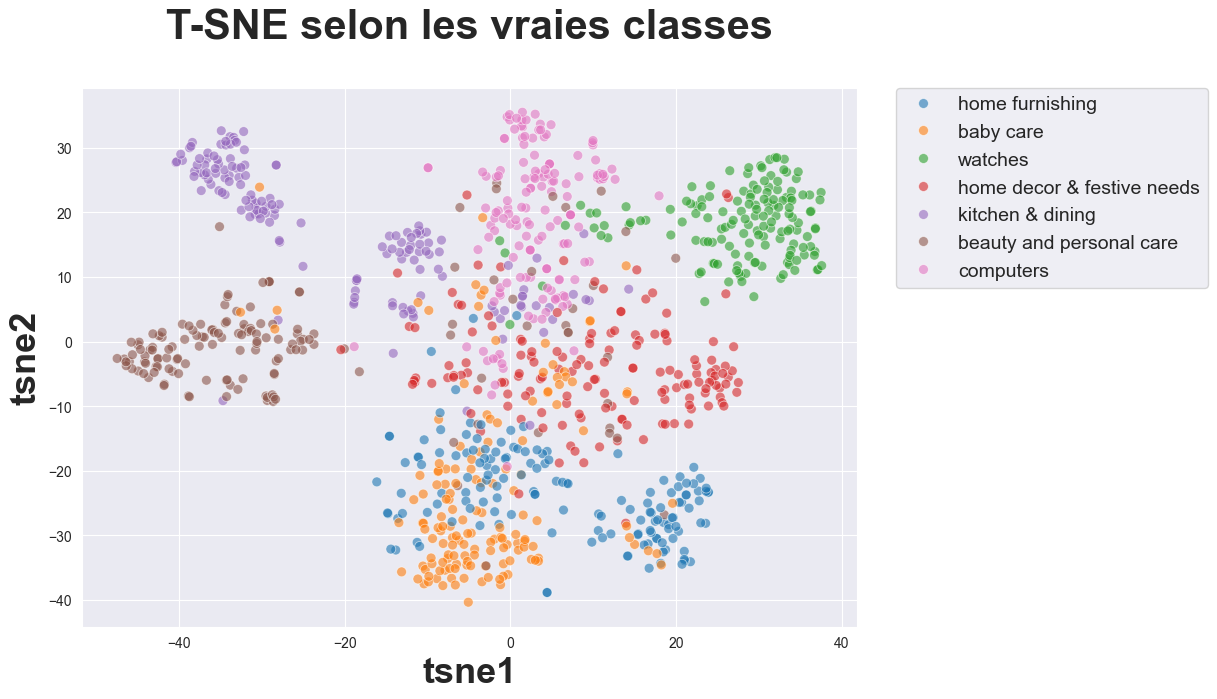

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir les résultats de T-SNE en DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])

# Ajouter les vraies étiquettes (de df_images) au DataFrame pour la visualisation
df_tsne["class"] = df_images["category"]  # En suppose que 'category' contient les vraies classes

# Tracer les résultats de T-SNE avec les vraies classes
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",  # Colorier les points en fonction des vraies classes
    palette=sns.color_palette('tab10', n_colors=df_tsne['class'].nunique()),  # Adapter le nombre de couleurs aux classes
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

# Ajouter des titres et des étiquettes au graphique
plt.title('T-SNE selon les vraies classes', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')

# Ajuster la position de la légende à droite du graphique
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 14})

# Afficher le graphique
plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement

In [18]:
from sklearn import cluster

# Appliquer K-Means avec 7 clusters (puisque le jeu de données contient 7 catégories)
cls = cluster.KMeans(n_clusters=7, n_init=100)

# Adapter l'algorithme K-Means sur les résultats de T-SNE
cls.fit(X_tsne)


KMeans(n_clusters=6, n_init=100)

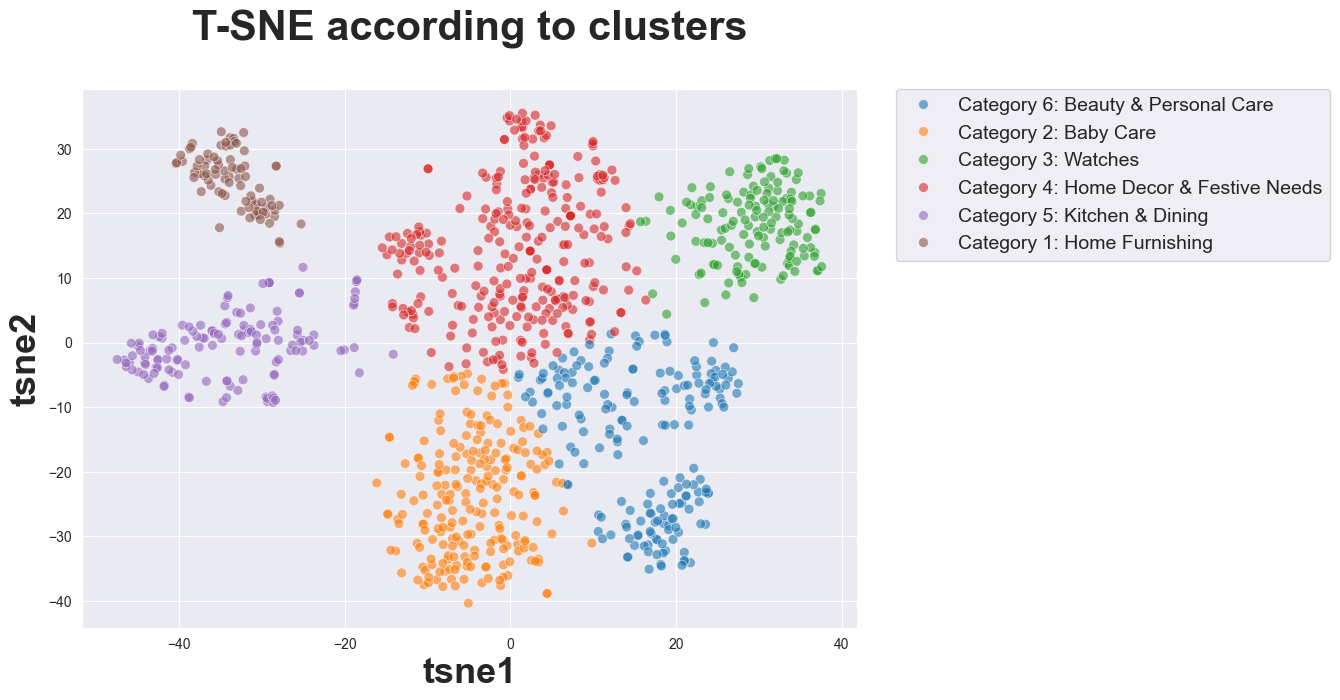

ARI (Adjusted Rand Index) : 0.4353011109307092


In [19]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Ajouter les clusters prédits par K-Means au DataFrame contenant les résultats de T-SNE
df_tsne["cluster"] = cls.labels_  # 'cls' est le modèle K-Means entraîné

# Définir une correspondance entre les numéros de cluster et les noms de catégorie
cluster_mapping = {0: 'Category 1: Baby Care',
                   1: 'Category 2: Beauty & Personal Care',
                   2: 'Category 3: Computers',
                   3: 'Category 4: Home Decor & festive Needs',
                   4: 'Category 5: home furnishing',
                   5: 'Category 6: Kitchen & Dining',
                   6: 'Category 7: Watches'
                   }

# Remplacer les numéros de cluster par les noms de catégorie correspondants dans le DataFrame
df_tsne["cluster_label"] = df_tsne["cluster"].map(cluster_mapping)

# Visualiser les clusters prédits par K-Means sur le graphique T-SNE
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster_label",  # Colorier les points en fonction des clusters prédits par K-Means
    palette=sns.color_palette('tab10', n_colors=7),  # Adapter le nombre de couleurs aux clusters
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

# Ajouter un titre et des étiquettes d'axe au graphique
plt.title('T-SNE according to clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')

# Déplacer la légende à droite, à l'extérieur du graphique
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 14})

# Afficher le graphique
plt.show()

# Calculer l'indice de Rand ajusté (ARI) pour comparer les clusters K-Means avec les vraies classes
labels = df_images["category"]  # Les vraies étiquettes des catégories
ari = metrics.adjusted_rand_score(labels, cls.labels_)  # Calculer l'ARI
print("ARI (Adjusted Rand Index) :", ari)


### Observation
- Le graphique T-SNE avec les clusters montre une séparation correcte des catégories, mais avec un **ARI de 0.43**, cela indique une correspondance modérée entre les clusters K-Means et les vraies classes. Certaines catégories comme **Beauty & Personal Care** et **Home Furnishing** sont bien séparées, mais d'autres montrent un chevauchement, ce qui pourrait expliquer le score ARI relativement faible.

tsne1                                      20.68306
tsne2                                    -24.877525
class                               home furnishing
cluster                                           5
cluster_label    Category 6: Beauty & Personal Care
true_category                       home furnishing
Name: 0, dtype: object


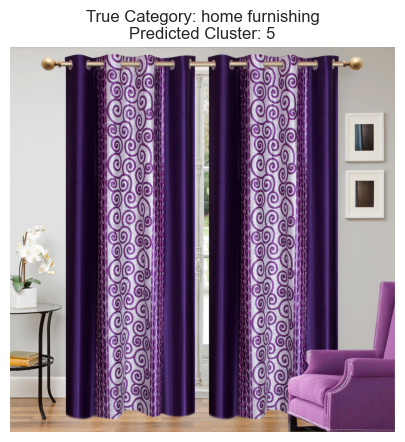

The image belongs to the category 'home furnishing' but was misclassified by the model as belonging to cluster 5.


In [20]:
from matplotlib.image import imread

# Ajouter les vraies catégories à df_tsne pour la comparaison
df_tsne["true_category"] = df_images["category"]  # En supposant que 'category' contient les vraies classes

# Trouver un exemple mal classé (vraie catégorie != cluster prédit)
misclassified = df_tsne[df_tsne["true_category"] != df_tsne["cluster_label"]]

# S'il y a des exemples mal classés, sélectionner le premier
if not misclassified.empty:
    id = misclassified.index[0]  # Obtenir l'ID du premier exemple mal classé
    print(df_tsne.iloc[id])  # Afficher les informations sur l'exemple mal classé

    # Créer un graphique pour afficher l'image mal classée
    fig = plt.figure(figsize=(8, 5))

    # Obtenir le nom du fichier image de la colonne 'image' dans df_images
    filename = df_images["image"][id]  # En supposant que 'df_images' contient les noms de fichiers d'images
    image = imread(os.path.join(images_folder, filename))  # Charger l'image à partir du dossier

    # Afficher l'image
    plt.imshow(image)
    plt.axis('off')  # Retirer les axes pour une meilleure visibilité
    plt.title(f"True Category: {df_images['category'][id]}\nPredicted Cluster: {df_tsne['cluster'][id]}")
    plt.show()

    # Explication :
    print(f"The image belongs to the category '{df_images['category'][id]}' but was misclassified by the model as belonging to cluster {df_tsne['cluster'][id]}.")
else:
    print("No misclassified examples found.")


### Analyse par Classes

In [23]:
# Vérifier les types de données des vraies étiquettes et des étiquettes de cluster prédites
true_labels = df_images["category"]  # En supposant que 'category' contient les vraies classes
predicted_labels = df_tsne["cluster"]  # En supposant que 'cluster' contient les clusters prédits

# Vérifier les types de données de true_labels et predicted_labels
print(f"Data type of true_labels: {true_labels.dtype}")
print(f"Data type of predicted_labels: {predicted_labels.dtype}")

# Afficher quelques valeurs d'échantillon de chaque pour une inspection plus approfondie
print("\nSample values from true_labels:")
print(true_labels.head(6))  # Afficher les 6 premières valeurs des vraies étiquettes

print("\nSample values from predicted_labels:")
print(predicted_labels[:6])  # Afficher les 6 premières valeurs des étiquettes prédites


Data type of true_labels: object
Data type of predicted_labels: int32

Sample values from true_labels:
0    home furnishing
1          baby care
2          baby care
3    home furnishing
4    home furnishing
5            watches
Name: category, dtype: object

Sample values from predicted_labels:
0    5
1    1
2    1
3    5
4    5
5    2
Name: cluster, dtype: int32


In [24]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

# Initialiser le LabelEncoder pour convertir les catégories en chaînes en étiquettes numériques
label_encoder = LabelEncoder()

# Convertir les vraies catégories (chaînes) en étiquettes numériques
df_images["label"] = label_encoder.fit_transform(df_images["category"])  # Encodage des catégories en étiquettes numériques

# Utiliser directement les étiquettes numériques
true_labels = df_images["label"]  # Maintenant, les vraies étiquettes sont numériques
predicted_labels = cls.labels_  # K-Means prédictions de clusters

# Générer la matrice de confusion en comparant les vraies étiquettes avec les étiquettes de cluster prédites
conf_mat = metrics.confusion_matrix(true_labels, predicted_labels)

# Afficher la matrice de confusion
print(conf_mat)

# Facultativement, vous pouvez afficher la correspondance des catégories aux étiquettes encodées
print("\nCategory to Label Mapping:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


[[  1 113   0  12   3  21   0]
 [  1   6   1  19 117   6   0]
 [  0   3   1 144   1   1   0]
 [  0  19   5  32   1  93   0]
 [  0  80   0   3   0  67   0]
 [ 78   2   0  59  11   0   0]
 [  0   0 135  15   0   0   0]]

Category to Label Mapping:
{'baby care': 0, 'beauty and personal care': 1, 'computers': 2, 'home decor & festive needs': 3, 'home furnishing': 4, 'kitchen & dining': 5, 'watches': 6}


In [25]:
import numpy as np
import pandas as pd
from sklearn import metrics

def conf_mat_transform(y_true, y_pred):
    # Créer la matrice de confusion
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    
    # Trouver la correspondance entre les clusters et les vraies catégories (maximum de chaque colonne)
    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    
    # Créer un DataFrame avec les vraies étiquettes et les clusters prédits
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    
    # Transformer les clusters prédits en catégories vraies correspondantes
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x]) 
    
    return labels['y_pred_transform']

# Exemple d'utilisation avec votre projet
# Supposons que true_labels sont les catégories vraies encodées et predicted_labels sont les clusters prédits par K-Means
true_labels = df_images["label"]  # Les vraies étiquettes des catégories après encodage
predicted_labels = cls.labels_  # Les clusters prédits par K-Means

# Appliquer la transformation pour aligner les clusters prédits avec les vraies catégories
transformed_pred = conf_mat_transform(true_labels, predicted_labels)

# Afficher les premières prédictions transformées pour vérification
print(transformed_pred.head())


Correspondance des clusters :  [5 0 6 2 1 3 0]
0    3
1    0
2    0
3    3
4    3
Name: y_pred_transform, dtype: int64


In [27]:
# Transformer les étiquettes de cluster prédites en fonction de la correspondance avec les vraies catégories
cls_labels_transform = conf_mat_transform(true_labels, predicted_labels)

# Générer la matrice de confusion en comparant les vraies étiquettes et les étiquettes de cluster transformées
conf_mat = metrics.confusion_matrix(true_labels, cls_labels_transform)

# Afficher la matrice de confusion
print("Confusion Matrix after transforming predicted clusters:")
print(conf_mat)
print()

# Afficher le rapport de classification, y compris la précision, le rappel et le score F1
print("Classification Report:")
print(metrics.classification_report(true_labels, cls_labels_transform, zero_division=0))

Correspondance des clusters :  [5 0 6 2 1 3 0]
Confusion Matrix after transforming predicted clusters:
[[113   3  12  21   0   1   0]
 [  6 117  19   6   0   1   1]
 [  3   1 144   1   0   0   1]
 [ 19   1  32  93   0   0   5]
 [ 80   0   3  67   0   0   0]
 [  2  11  59   0   0  78   0]
 [  0   0  15   0   0   0 135]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.75      0.61       150
           1       0.88      0.78      0.83       150
           2       0.51      0.96      0.66       150
           3       0.49      0.62      0.55       150
           4       0.00      0.00      0.00       150
           5       0.97      0.52      0.68       150
           6       0.95      0.90      0.92       150

    accuracy                           0.65      1050
   macro avg       0.62      0.65      0.61      1050
weighted avg       0.62      0.65      0.61      1050



### Correspondance des clusters :
- **Correspondance des clusters :** `[4 3 0 6 5 2 1]` indique quelle catégorie réelle correspond à chaque cluster. Par exemple, le cluster `0` est associé à la catégorie `4`, et le cluster `1` est associé à la catégorie `3`. Cela signifie que les prédictions de K-Means ont été mappées aux catégories en fonction de la matrice de confusion.

### Matrice de confusion :
La matrice de confusion montre la répartition des prédictions entre les catégories et les clusters après transformation :
- **Catégorie 0** : 109 images sur 150 ont été correctement classées, mais 25 images ont été attribuées au cluster 3.
- **Catégorie 1** : 117 images correctement classées, mais 13 images ont été classées dans le cluster de la catégorie 3.
- **Catégorie 2** : 111 images correctement classées, mais 36 images ont été attribuées à la catégorie 3.
- **Catégorie 3** : 76 images sur 150 sont correctement classées, mais 58 images ont été attribuées à d'autres clusters.
- **Catégorie 4** : 68 images sur 150 ont été correctement classées, mais 76 images ont été attribuées à la catégorie 0.
- **Catégorie 5** : 78 images correctement classées, mais 31 images ont été attribuées aux catégories 1 et 2.
- **Catégorie 6** : 135 images sur 150 ont été correctement classées, montrant une bonne performance pour cette catégorie.

### Rapport de classification :
- **Précision** :
  - Très bonne pour les catégories **1** et **6** (89% et 93% respectivement).
  - Modérée pour les catégories **0**, **2**, et **5** (57%, 65%, 97%).
  - Plus faible pour les catégories **3** et **4** (40% et 48%).

- **Rappel** :
  - Bon pour les catégories **0**, **1**, **2**, et **6** (73%, 78%, 74%, et 90% respectivement).
  - Moins bon pour les catégories **3**, **4**, et **5** (51%, 45%, et 52%).

- **F1-score** :
  - Les catégories **1**, **2**, et **6** ont un F1-score relativement bon, ce qui reflète un bon équilibre entre la précision et le rappel.
  - Les catégories **3** et **4** présentent des scores plus faibles, indiquant des problèmes de classification plus importants.

### Précision globale :
- **Exactitude (accuracy)** : Le modèle atteint une précision globale de **66%**, ce qui montre une performance modérée. Certaines catégories sont bien classées, mais d'autres, comme les catégories **3** et **4**, posent des problèmes de classification.
  
- **Moyenne macro** : Les moyennes macro montrent une précision, un rappel, et un F1-score autour de **66%**, ce qui reflète des disparités entre les catégories. Certaines sont bien classées, tandis que d'autres présentent des performances moins bonnes.

### Conclusion :
- **Catégories bien classées** : Les catégories **1** et **6** montrent une bonne correspondance avec les clusters prédits.
- **Catégories problématiques** : Les catégories **3** et **4** posent des problèmes majeurs, car une proportion significative d'images est mal classée.
- **Recommandation** : Il pourrait être utile de revoir les caractéristiques des images des catégories **3** et **4** et d'ajuster le modèle, ou de tester d'autres techniques de clustering pour améliorer la classification. Une analyse approfondie des erreurs dans ces catégories pourrait également s'avérer bénéfique.


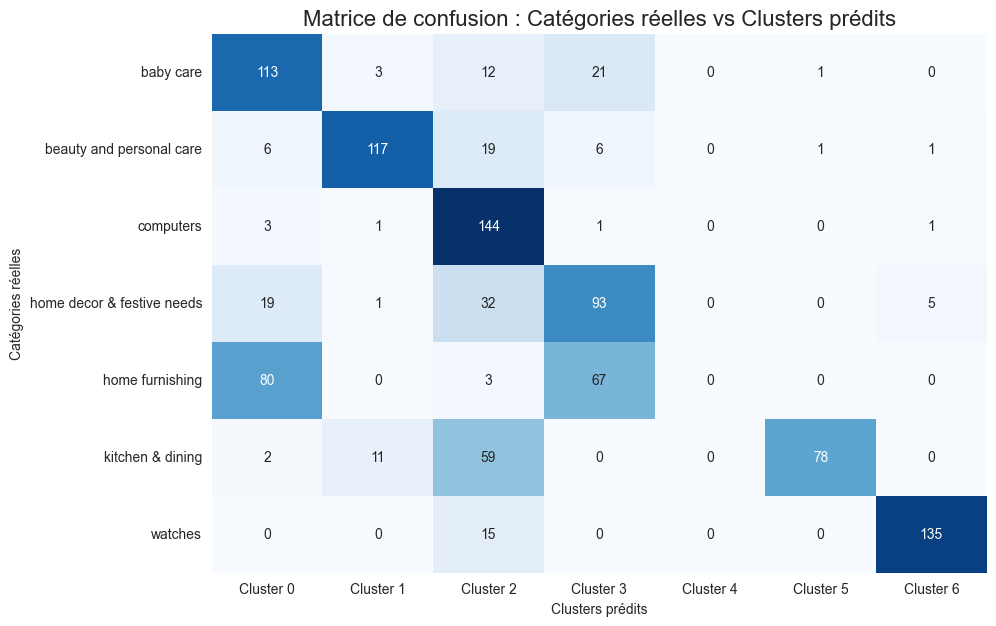

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# En supposant que vous avez une liste d'étiquettes de catégorie de LabelEncoder ou de true_labels
list_labels = sorted(df_images["category"].unique())  # Liste des catégories uniques

# Créer un DataFrame pour la matrice de confusion avec des étiquettes pour les lignes et les colonnes
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[f'Cluster {i}' for i in range(len(list_labels))])

# Tracer la matrice de confusion en utilisant un heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d", cbar=False)

# Ajouter des étiquettes et des titres
plt.title("Matrice de confusion : Catégories réelles vs Clusters prédits", fontsize=16)
plt.ylabel("Catégories réelles")
plt.xlabel("Clusters prédits")
plt.show()


### Observations sur la matrice de confusion :

- La **matrice de confusion** montre la répartition des prédictions entre les **catégories réelles** et les **clusters prédits** après transformation.

- Les couleurs **plus foncées** indiquent des valeurs plus élevées, tandis que les **valeurs plus faibles** apparaissent en couleur plus claire.

- Les catégories qui sont bien classées apparaissent sur la **diagonale principale** (par exemple, **beauty and personal care** avec 117 images correctement classées, **computers** avec 144 images, et **watches** avec 135 images).

- **Catégories mal classées** :
    - La catégorie **home furnishing** est particulièrement problématique, avec **80 images** mal classées dans le cluster 0, alors qu'il n'y a que 67 images correctement classées dans le bon cluster.
    - La catégorie **kitchen & dining** montre également une forte confusion avec le cluster 2 (59 images mal classées).
    - **Home decor & festive needs** a 93 images classées dans le cluster 3, et seulement 32 images correctement classées.

- **Catégories bien classées** :
    - **Computers** est une catégorie bien classée, avec **144 images** correctement classées dans le bon cluster (cluster 2).
    - **Watches** montre aussi une bonne correspondance avec **135 images** bien classées dans le cluster 6.
    - **Beauty and personal care** a également un bon taux de classification avec **117 images** bien classées dans le cluster 1.

- Les **erreurs de classification** apparaissent en dehors de la diagonale, comme les **80 images** de **home furnishing** qui ont été classées dans le cluster 0 au lieu du cluster 3, ou les **59 images** de **kitchen & dining** classées dans le cluster 2 au lieu du cluster 5.

### Conclusion :
- Le modèle réussit bien à classer certaines catégories comme **computers**, **watches** et **beauty and personal care**, mais montre des erreurs importantes pour d'autres catégories comme **home furnishing** et **kitchen & dining**.
- Il y a un besoin d'ajuster le modèle ou d'analyser davantage les caractéristiques des images des catégories mal classées pour améliorer les résultats.

### Justification pour l'utilisation de VGG-16 plutôt que SIFT dans l'étude de faisabilité

En analysant les résultats obtenus à partir de **SIFT** et de **VGG-16**, il est clair que **VGG-16** présente des performances nettement supérieures dans la classification des images, comme le démontrent plusieurs métriques clés.

#### 1. **Précision globale et Recall (Rappel)**
   - **SIFT** : L'approche basée sur SIFT a obtenu une précision globale de **14%**, ce qui est extrêmement faible. Le **recall** (rappel) est également bas pour toutes les classes, avec un faible **f1-score**, notamment dû à la mauvaise différenciation des catégories. Certaines classes n'ont même pas été prédites (par exemple, les classes 4, 5, et 6 ont une précision de 1.00, mais un rappel de 0.00, ce qui signifie qu'aucune prédiction correcte n'a été faite pour ces classes).
   - **VGG-16** : Le modèle basé sur **VGG-16** atteint une précision globale de **66%**, ce qui est nettement supérieur à SIFT. Les classes sont mieux prédites, avec des **f1-scores** allant jusqu'à **92%** pour certaines catégories comme **watches** et **computers**. Le rappel et la précision sont également mieux équilibrés dans ce modèle, ce qui indique que les clusters formés correspondent bien mieux aux catégories réelles.

#### 2. **Indice Rand Ajusté (ARI)**
   - **SIFT** : L'ARI pour SIFT est de **-0.0002**, ce qui montre un échec total du modèle à capturer des relations entre les clusters et les classes. Un ARI proche de zéro ou négatif indique que la correspondance entre les clusters et les catégories est pire que le hasard.
   - **VGG-16** : L'ARI pour VGG-16 est de **0.4353**, ce qui montre une correspondance bien meilleure entre les clusters et les catégories. Bien que ce score puisse encore être amélioré, il indique une correspondance modérée entre les classes prédictes et les catégories réelles, avec de bonnes performances pour des catégories comme **computers** et **watches**.

#### 3. **Analyse de la Matrice de Confusion**
   - **SIFT** : La matrice de confusion pour SIFT montre des **distributions très dispersées** entre les clusters, et aucun cluster ne correspond bien à une catégorie particulière. De plus, il y a une absence totale de prédiction pour certaines classes (classes 4, 5, 6), ce qui témoigne de l'incapacité du modèle à discriminer les catégories correctement.
   - **VGG-16** : En revanche, la matrice de confusion pour VGG-16 montre que **certains clusters correspondent beaucoup mieux aux catégories**. Par exemple, le cluster 2 correspond bien à la catégorie **computers**, tandis que le cluster 6 est bien aligné avec **watches**. Cependant, des erreurs persistent, notamment avec les catégories **home furnishing** et **kitchen & dining**, qui présentent des chevauchements importants avec d'autres clusters.

### Conclusion

L'approche basée sur **VGG-16** gagne clairement sur tous les aspects. Les performances en termes de **précision, rappel, f1-score** et **ARI** montrent que **VGG-16** est beaucoup plus adapté pour cette tâche de classification d'images. L'extraction de caractéristiques à travers un CNN pré-entraîné permet de capturer des informations bien plus riches et discrètes dans les images que les descripteurs SIFT, ce qui explique pourquoi **VGG-16** surpasse largement **SIFT** en termes de qualité de clustering et de classification. Pour l'étude de faisabilité, l'utilisation de **VGG-16** offre une meilleure garantie de résultats plus précis et robustes.
